First, let's create some random data to simulate particles inside a simulation box.

If using a .gro coordinate file, the functions.py module provides a helper function that can transcribe the file into mapped particle coordinates along with their corresponding radii.

The code implements a probe insertion method to capture the void size distribution. The simulation box, containing the particles (treated as spheres), is discretized into cubes defined by the number of grid points (number_grid_points).

At the center of each cube (grid center), an initial probe sphere with a radius of 0.001 nm is inserted. The algorithm checks for overlaps between the probe sphere and the existing particles:

    If an overlap is detected, it moves to the next grid center.

    If no overlap is found, the probe sphere’s radius is increased by 0.001 nm (step_size) until it intersects with an existing sphere.

    If two inserted probe spheres overlap, the algorithm prioritizes the larger sphere to better capture the void regions.

After the insertion of probe spheres, the derivative of the distribution function is taken.

Box dimensions (nm)
[3, 3, 3]
Grid points total: 3,375
Purged (void) points: 204
Uniform centers (ngrid=5): 3375
Parent cell size (nm): x:0.2000, y:0.2000, z:0.2000
Grid cube volume (nm^3): 0.008000
Estimated pair checks (centers × dots): 1019796


Processing grid centers: 100%|██████████| 204/204 [00:00<00:00, 371.01it/s]


# maximal spheres kept: 204
The area under the curve is:1.0
Elapsed time: 1.5113129615783691 seconds
The dictionary has been saved as /raid6/homes/ordoriaf/work/VoidSizeAnalyzer/results/PSD_histogram.json
The dictionary has been saved as /raid6/homes/ordoriaf/work/VoidSizeAnalyzer/results/PSD_Cumulative.json
The dictionary has been saved as /raid6/homes/ordoriaf/work/VoidSizeAnalyzer/results/PSD_derivative.json


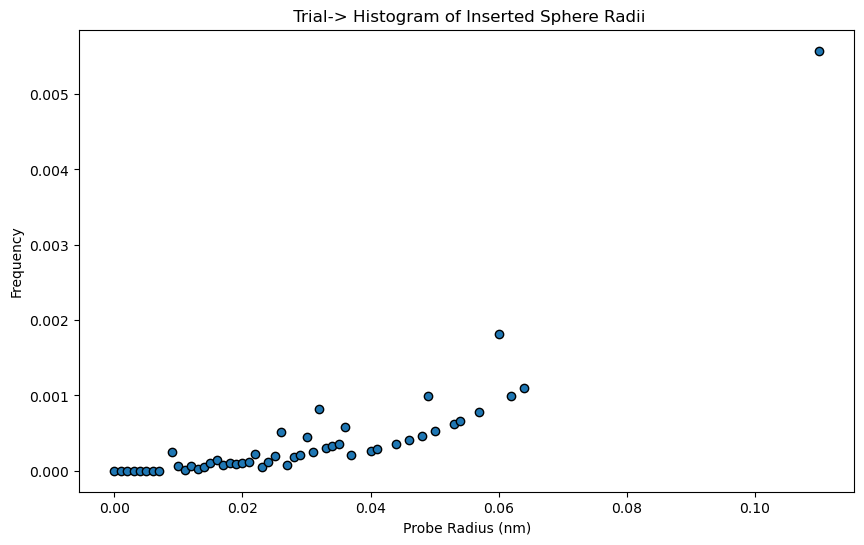

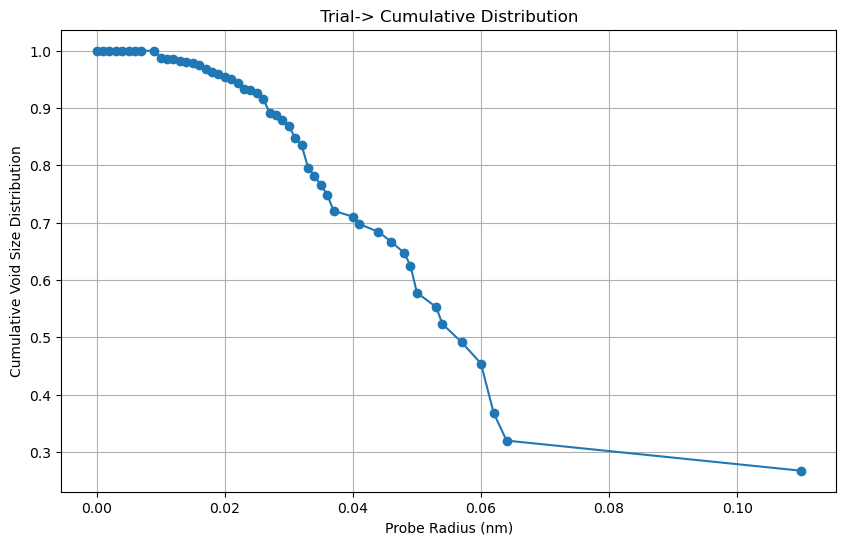

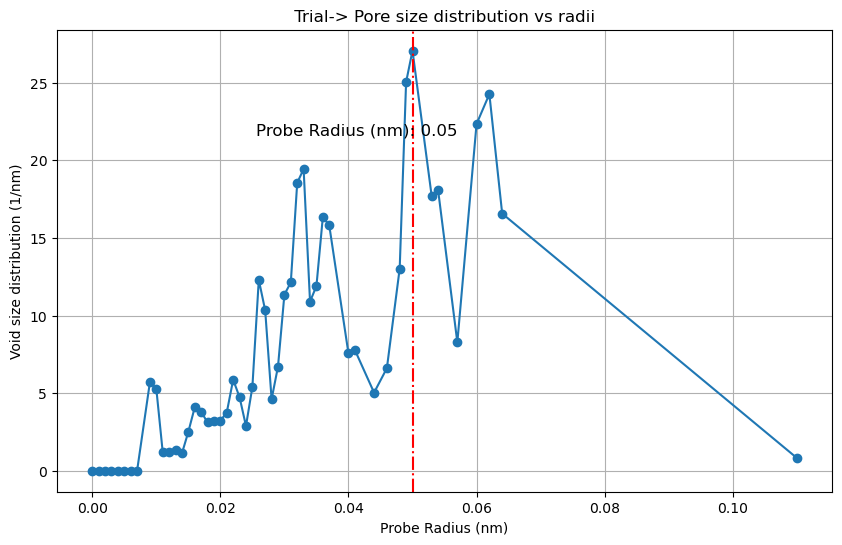

In [1]:
import time
import pickle 
from functions import *

file_path = os.getcwd() + "/results"
data = []
for i in range(1, 5000):
    dot = {
        "name": f"dot{i}",
        "x": uniform(0, 3),
        "y": uniform(0, 3),
        "z": uniform(0, 3),
        "radius": uniform(0.1, 0.2)  # Random radius between 0.1 and 1.5
    }
    data.append(dot)

########################################################################################################################
start_time = time.time()
unique_radii, counts, cdf_reversed,  derivative, x_fit, y_fit, params, sphere_list = VSD(data,
                                                                            number_grid_points = 5, 
                                                                            box_dimensions_array = [3,3,3],
                                                                            step_size = 0.001, # In nm (radius) was 0.001
                                                                            units = "nm",
                                                                            diameter=False,
                                                                            Gaussian_Fit = False, 
                                                                            GPU = False)
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

PSD_histogram = {k: v for k, v in zip(unique_radii, counts)}
PSD_Cumulative = {k: v for k, v in zip(unique_radii, cdf_reversed)}
PSD_derivative = {k: v for k, v in zip(unique_radii, derivative)}

######## 1 #################################################################
with open(os.path.join(file_path, "PSD_histogram_trial.json"), 'w') as json_file:
    json.dump(PSD_histogram, json_file, indent=4)

print(f'The dictionary has been saved as {os.path.join(file_path, "PSD_histogram.json")}')
################################################################################################

######## 2 #################################################################
with open(os.path.join(file_path, "PSD_Cumulative_trial.json"), 'w') as json_file:
    json.dump(PSD_Cumulative, json_file, indent=4)

print(f'The dictionary has been saved as {os.path.join(file_path, "PSD_Cumulative.json")}')
################################################################################################

######## 3 #################################################################
with open(os.path.join(file_path, "PSD_derivative_trial.json"), 'w') as json_file:
    json.dump(PSD_derivative, json_file, indent=4)

print(f'The dictionary has been saved as {os.path.join(file_path, "PSD_derivative.json")}')
################################################################################################
with open(os.path.join(file_path, 'sphere_list_trial.pyx'), 'wb') as file:
    pickle.dump(sphere_list, file)


plot_VSD(file_path, unique_radii,counts,cdf_reversed, derivative, units = "nm", Diameter = False , save = True, case = "Trial->" )

Now let's plot the void spaces

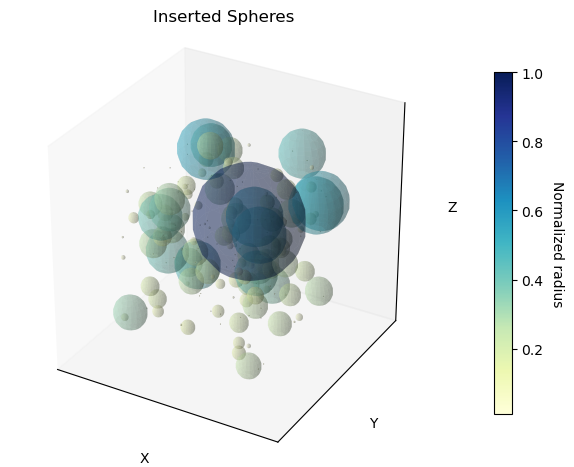

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

file_path = os.getcwd() + '/results/'

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
# Plot ONLY the filtered spheres into this single axes
load_and_plot_single_with_colorbar(file_path,
                                    file_suffix="_trial",
                                    ax=ax,
                                    title="Inserted Spheres",
                                      filter_by_radius=False)

plt.tight_layout()
plt.savefig(os.path.join(file_path, f"Visual_Rendition_VOID_space.png"), bbox_inches='tight', dpi=600)


Now let's make a demonstration of the way the boundary of the original compound is fitted into the grid created to determine the centers
This way of doing things ensures:
1) Purging out initial overlapping grid centers with actual atoms
2) Wrapping the edges of the compound to avoid surface artifacts

In [3]:
number_grid_points = 10
#########################
file_path_gro = os.getcwd() + '/trial_gro/Swollen_scaffold.gro'
##############################################################################################
data, box_d = transcribe_gro_radius(file_path_gro, crop_edges=False, threshold=0.0, nbins=100)
dots_data = np.array([(dot["x"], dot["y"], dot["z"], dot["radius"]) for dot in data])
box_dimensions = {'x': box_d[0], 'y': box_d[1], 'z': box_d[2]}
n_x = max(1, int(number_grid_points * box_dimensions['x']))
n_y = max(1, int(number_grid_points * box_dimensions['y']))
n_z = max(1, int(number_grid_points * box_dimensions['z']))

cube_length_x = box_dimensions['x'] / n_x
cube_length_y = box_dimensions['y'] / n_y
cube_length_z = box_dimensions['z'] / n_z

x = np.arange(0, box_dimensions['x'], cube_length_x) + cube_length_x / 2
y = np.arange(0, box_dimensions['y'], cube_length_y) + cube_length_y / 2
z = np.arange(0, box_dimensions['z'], cube_length_z) + cube_length_z / 2

x = x[x < box_dimensions['x']]
y = y[y < box_dimensions['y']]
z = z[z < box_dimensions['z']]

grid_x, grid_y, grid_z = np.meshgrid(x, y, z, indexing='ij')
parent_centers = np.column_stack((grid_x.ravel(), grid_y.ravel(), grid_z.ravel()))
uniform_centers = parent_centers.shape[0]
#
grid_pts = parent_centers

purged_centers, original_centers = Boundary_Convex_Hull(grid_pts,dots_data )

Initial number of atoms: 11343
Box dimensions (original) (nm): [5.614 4.679 7.449]
Length of Radius list: 11343
Box dimensions (final) (nm): [5.614 4.679 7.449]
Grid points total: 190,624
Purged (void) points: 103,211


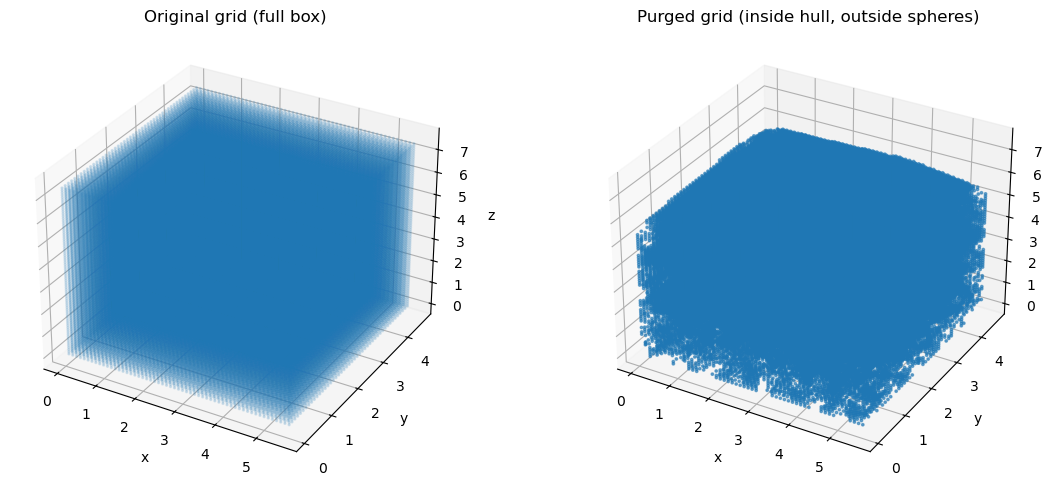

In [4]:
# --- plot original vs purged grid ---
orig_pts = original_centers
purged_pts =  purged_centers
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(orig_pts[:,0], orig_pts[:,1], orig_pts[:,2], s=2, alpha=0.15)
ax1.set_title("Original grid (full box)")
ax1.set(xlabel='x', ylabel='y', zlabel='z')

ax2 = fig.add_subplot(122, projection='3d')
if purged_pts.size:
    ax2.scatter(purged_pts[:,0], purged_pts[:,1], purged_pts[:,2], s=3, alpha=0.6)
ax2.set_title("Purged grid (inside hull, outside spheres)")
ax2.set(xlabel='x', ylabel='y', zlabel='z')

plt.tight_layout()
plt.show()


By performing this we got a reduction in total number of grid points from 190,624 initial centers to 103,211; 46% reduction in centers!